In [1]:
!git clone https://github.com/Cajeux1999/AEMO-Solar-Energy-Forecasting.git -q

In [2]:
!pip install arfs
!pip install lightgbm
from arfs.preprocessing import OrdinalEncoderPandas
import arfs
import arfs.preprocessing as arfspp
import arfs.feature_selection as arfsfs
from arfs.feature_selection.allrelevant import GrootCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from arfs.benchmark import highlight_tick
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.pyplot as plt
import arfs.feature_selection.allrelevant as arfsgroot
from lightgbm import LGBMRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [3]:
REPO_NAME = "AEMO-Solar-Energy-Forecasting"
%cd {REPO_NAME}

from src import config, utils
train_size = config.TRAIN_SIZE

#Defining the filepath to load the dataset
filepath_processed = '/content/AEMO-Solar-Energy-Forecasting/data/processed/'
filepath_raw = '/content/AEMO-Solar-Energy-Forecasting/data/raw/'

/content/AEMO-Solar-Energy-Forecasting


In [4]:
#Loading the dataset with the features generated in 2. Feature_Engineering
X = pd.read_csv(filepath_processed+'df_features_preprocessed.csv')
X.drop(columns='Unnamed: 0',inplace=True)

#Loading the target series of solar generation
y = pd.read_csv(filepath_raw+'nsw_solar.csv')

In [5]:
#Separating the train sets
X_train = X[:train_size].drop(columns=["ds"])  # se ds for o timestamp
y_train = y[:train_size].drop(columns=["ds","unique_id"]).drop(columns='Unnamed: 0').squeeze()

In [6]:
#Removing some special characters from the features names, that can't be processed by ARFS
X_train = X_train.rename(
    columns=lambda c: re.sub(r'[^A-Za-z0-9_]+', '_', c)
)

In [ ]:
#Instantiating a Cross validation strategy based on TimeSeriesSplit,
#Will be used to feature selection via ARFS
ts_cv = TimeSeriesSplit(
    n_splits=5
)

In [ ]:
def plot_tscv_folds(tscv, X):
    n_folds = tscv.get_n_splits()

    fig, ax = plt.subplots(figsize=(14, 1.8 + n_folds))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        # Subtrain
        ax.scatter(
            train_idx,
            np.full_like(train_idx, fold),
            marker="|",
            s=200,
            color="tab:blue",
            label="Subtrain" if fold == 0 else ""
        )

        # Validation
        ax.scatter(
            val_idx,
            np.full_like(val_idx, fold),
            marker="|",
            s=200,
            color="tab:orange",
            label="Validation" if fold == 0 else ""
        )

    ax.set_yticks(range(n_folds))
    ax.set_yticklabels([f"Fold {i}" for i in range(n_folds)])
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Fold Number")
    ax.set_title("TimeSeriesSplit – Subtrain vs Validation")

    ax.legend(loc="upper left")
    ax.grid(True, axis="x", alpha=0.3)

    plt.tight_layout()
    plt.show()


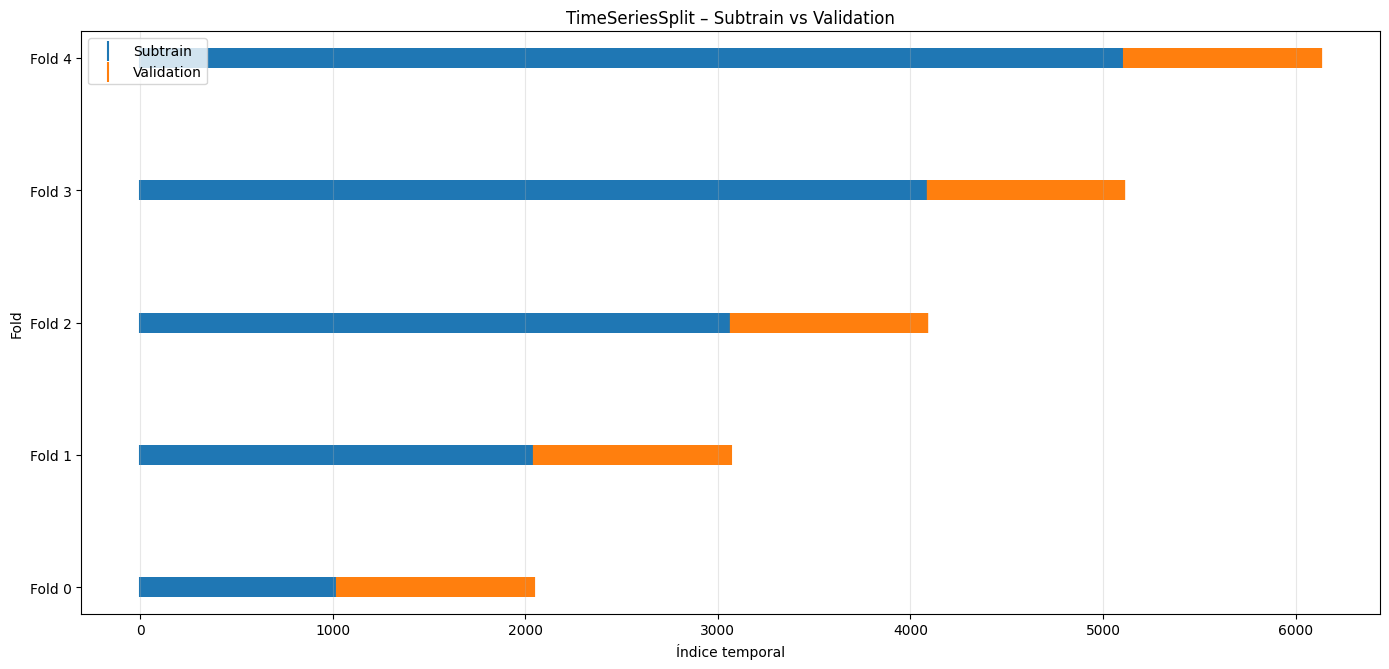

In [ ]:
plot_tscv_folds(ts_cv, X_train)

## ARFS Feature Selection

In [ ]:
model = LGBMRegressor(random_state=42, verbose=-1)

In [ ]:
features_por_fold = {}

for fold, (subtrain_idx, val_idx) in enumerate(ts_cv.split(X_train)):
    print(f"\n===== Fold {fold} =====")

    X_sub = X_train.iloc[subtrain_idx]
    y_sub = y_train.iloc[subtrain_idx]


    selector = arfsgroot.Leshy(
    model, verbose=1, random_state=42, n_estimators=100, importance="shap"
    )

    selector.fit(X_sub, y_sub)

    selected_features = selector.get_feature_names_out()

    # guarda por fold (opcional, mas útil)
    features_por_fold[fold] = selected_features

    print(f"{len(selected_features)} features selecionadas")


===== Fold 0 =====


Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 100
Confirmed: 	94
Tentative: 	10
Rejected: 	415
All relevant predictors selected in 00:09:27.62
94 features selecionadas

===== Fold 1 =====


Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 100
Confirmed: 	135
Tentative: 	15
Rejected: 	369
All relevant predictors selected in 00:13:56.08
135 features selecionadas

===== Fold 2 =====


Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 100
Confirmed: 	133
Tentative: 	18
Rejected: 	368
All relevant predictors selected in 00:15:00.04
133 features selecionadas

===== Fold 3 =====


Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 100
Confirmed: 	150
Tentative: 	22
Rejected: 	347
All relevant predictors selected in 00:17:52.40
150 features selecionadas

===== Fold 4 =====


Leshy iteration:   0%|          | 0/100 [00:00<?, ?it/s]



Leshy finished running using shap var. imp.

Iteration: 	1 / 100
Confirmed: 	160
Tentative: 	16
Rejected: 	343
All relevant predictors selected in 00:21:31.84
160 features selecionadas


In [ ]:
n_features_por_fold = {
    fold: len(feats)
    for fold, feats in features_por_fold.items()
}

n_features_por_fold


{0: 94, 1: 135, 2: 133, 3: 150, 4: 160}

In [ ]:
from collections import Counter

n_folds = len(features_por_fold)

counter = Counter()
for feats in features_por_fold.values():
    counter.update(feats)

df_features = (
    pd.DataFrame(counter.items(), columns=["feature", "count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)

df_features["freq_rel"] = df_features["count"] / n_folds


In [19]:
df_features

,Unnamed: 0,feature,count,freq_rel
0,0,y__partial_autocorrelation__lag_3,5,1.0
1,1,y__ar_coefficient__coeff_3__k_10,5,1.0
2,2,y__fft_coefficient__attr__angle___coeff_43,5,1.0
3,3,y__agg_linear_trend__attr__rvalue___chunk_len_...,5,1.0
4,4,y__agg_linear_trend__attr__rvalue___chunk_len_...,5,1.0
...,...,...,...,...
323,323,y__fft_coefficient__attr__angle___coeff_65,1,0.2
324,324,y__fft_coefficient__attr__angle___coeff_76,1,0.2
325,325,y__fft_coefficient__attr__angle___coeff_84,1,0.2
326,326,y__ratio_beyond_r_sigma__r_1,1,0.2


In [15]:
features_filtered = df_features[df_features['count'].isin([4,5])]

features_list = list(features_filtered['feature'])

In [18]:
features_list

['y__partial_autocorrelation__lag_3',
 'y__ar_coefficient__coeff_3__k_10',
 'y__fft_coefficient__attr__angle___coeff_43',
 'y__agg_linear_trend__attr__rvalue___chunk_len_50__f_agg__min_',
 'y__agg_linear_trend__attr__rvalue___chunk_len_5__f_agg__var_',
 'y__fft_coefficient__attr__angle___coeff_44',
 'y__fft_coefficient__attr__imag___coeff_43',
 'halfhour_cos',
 'air_temp',
 'y__agg_linear_trend__attr__stderr___chunk_len_50__f_agg__min_',
 'y__agg_linear_trend__attr__slope___chunk_len_50__f_agg__mean_',
 'y__last_location_of_maximum',
 'y__mean_second_derivative_central',
 'y__partial_autocorrelation__lag_4',
 'y__change_quantiles__f_agg__mean___isabs_False__qh_0_8__ql_0_0',
 'y__fft_coefficient__attr__imag___coeff_97',
 'y__change_quantiles__f_agg__mean___isabs_False__qh_1_0__ql_0_8',
 'y__fft_coefficient__attr__abs___coeff_89',
 'y__fft_coefficient__attr__angle___coeff_4',
 'y__change_quantiles__f_agg__mean___isabs_False__qh_1_0__ql_0_6',
 'y__fft_coefficient__attr__angle___coeff_60',

In [17]:
len(features_list)

43

In [20]:
X = X.rename(
    columns=lambda c: re.sub(r'[^A-Za-z0-9_]+', '_', c)
)

#Filtering only the selected features to the X dataset
X = X[['ds'] + features_list]

In [21]:
X.tail(5)

,ds,y__partial_autocorrelation__lag_3,y__ar_coefficient__coeff_3__k_10,y__fft_coefficient__attr__angle___coeff_43,y__agg_linear_trend__attr__rvalue___chunk_len_50__f_agg__min_,y__agg_linear_trend__attr__rvalue___chunk_len_5__f_agg__var_,y__fft_coefficient__attr__angle___coeff_44,y__fft_coefficient__attr__imag___coeff_43,halfhour_cos,air_temp,...,y__fft_coefficient__attr__real___coeff_19,y__fft_coefficient__attr__imag___coeff_3,y__fft_coefficient__attr__imag___coeff_16,y__fft_coefficient__attr__imag___coeff_59,y__fft_coefficient__attr__angle___coeff_75,y__fft_coefficient__attr__angle___coeff_6,y__fft_coefficient__attr__abs___coeff_5,y__fft_coefficient__attr__abs___coeff_8,y__partial_autocorrelation__lag_9,y__ar_coefficient__coeff_4__k_10
8780,2024-12-30 22:00:00,0.124274,0.115751,-74.722103,0.163323,0.116822,23.176011,-77542.894309,0.866025,24,...,-33232.482691,538160.794449,148386.925033,67158.138515,103.902170,174.748737,615101.185203,390207.066668,-0.051398,0.023087
8781,2024-12-30 22:30:00,0.124279,0.115751,-74.007084,0.163323,0.116822,24.512822,-77338.608563,0.923880,24,...,-35093.860476,538474.805194,149574.944739,66065.301353,106.150490,175.418179,614665.800245,390052.715426,-0.051840,0.023087
8782,2024-12-30 23:00:00,0.124285,0.115751,-73.289658,0.163323,0.116822,25.860400,-77119.866310,0.965926,23,...,-36957.172147,538785.694239,150742.810254,64831.891431,108.388225,176.070100,614230.371653,389899.248815,-0.052222,0.023087
8783,2024-12-30 23:30:00,0.124291,0.115752,-72.569679,0.163323,0.116822,27.219052,-76886.496567,0.991445,23,...,-38822.136930,539093.462070,151890.447938,63460.510877,110.615738,176.705285,613794.902292,389746.670987,-0.052472,0.023087
8784,2024-12-31 00:00:00,0.124297,0.115753,-71.847001,0.163323,0.116822,28.589090,-76638.319781,1.000000,23,...,-40688.473247,539398.109186,153017.786488,61953.977281,112.833377,177.324474,613359.395024,389594.986047,-0.052472,0.023088


In [22]:
X.to_csv(filepath_processed+'X.csv')